In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from RNN_block import RNN_block
import pennylane as qml
import pandas as pd

In [3]:
df = pd.read_csv('./dataset.csv')

In [4]:
n_train = 50

y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T
print(xs[1])
y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


tensor([1.7476e-02, 2.3959e+01, 3.5131e-02, 1.2807e+01])


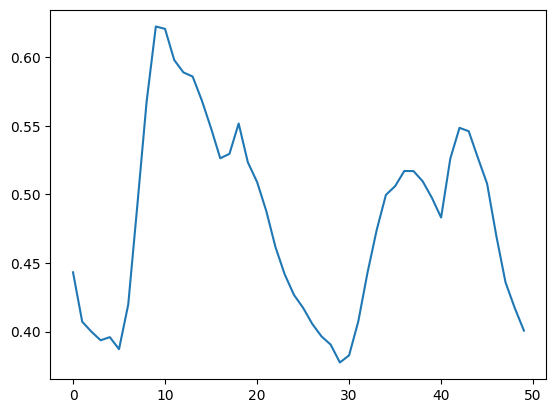

In [157]:
plt.plot(nn.Sigmoid()(y_train-0.5))
plt.show()

In [ ]:
import pennylane as qml
class RNN_block:
    def __init__(self, input_size):
        self.input_size = input_size

    
    def embedding(self, params):
        n = (self.input_size + 1) // 2
        for i in range(n):
            qml.Hadamard(i)
            qml.RZ(2.0 * params[:,i], i)
        
        for i in range(n - 1):
            qml.IsingZZ(2.0 * params[:,n + i] ,[i , i + 1])
    
    def ansatz(self, params, all_entangled = False):
        # Length of Params : 3 * num_qubit
        n = self.input_size
        for i in range(n):
            qml.RX(params[3 * i], i)
            qml.RY(params[3 * i + 1], i)
            qml.RZ(params[3 * i + 2], i)
        for i in range(n - 1):
            qml.CNOT([i, i + 1])
        if all_entangled:
            qml.CNOT([n - 1, 0])

In [123]:
class G1(nn.Module):
    '''
    G for V(G)
    '''
    def __init__(self, input):
        super(G1, self).__init__()
        self.li1 = nn.Linear(input,16)
        self.li2 = nn.Linear(16, 16)
        self.li3 = nn.Linear(16, 2*input-1)
        
    def forward(self, x):
        x = self.li1(x)
        x = F.relu(x)
        x = self.li2(x)
        x = F.relu(x)
        x = self.li3(x)
        x = 2*torch.pi*F.relu(x)
        return x

In [124]:
n_qu = 4
dev = qml.device("default.qubit", wires = n_qu)

def embedding(params, n_qu):
    '''
    embedding layer
    '''
    n = n_qu
    for i in range(n):
        qml.Hadamard(i)
        qml.RZ(2.0 * params[:,i], i)
    
    for i in range(n - 1):
        qml.IsingZZ(2.0 * params[:,n + i] ,[i , i + 1])

@qml.qnode(dev, interface="torch")
def fidelity(vec1, vec2, n_qu):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    embedding(vec1, n_qu) # Phi(x1) circuit 적용
    qml.adjoint(embedding)(vec2, n_qu) # Phi^t(x2) 적용
    return qml.probs()


In [125]:
class feature_train(nn.Module):
    def __init__(self,n_qu):
        super(feature_train, self).__init__()
        self.n_qu = n_qu
        self.linear1 = G1(input=n_qu)
        self.quantum_layer = fidelity
    def forward(self,input1,input2):
        input1 = self.linear1(input1)
        input2 = self.linear1(input2)
        output = self.quantum_layer(input1,input2,self.n_qu)[:,0]
        return output
        
        

In [168]:
epochs = 50

model = feature_train(n_qu)

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.003, betas=[0.9,0.999])

for epoch in range(epochs):
    optimizer.zero_grad()
    risk = 0
    f_loss_list = []

    for i in range(n_train-1):
        train_data = torch.stack([xs,torch.concat([xs[(i+1):],xs[:(i+1)]])])
        label_data = torch.stack([y_train,torch.concat([y_train[(i+1):],y_train[:(i+1)]])])
        f_loss = model(train_data[0],train_data[1])
        loss = -torch.sum(torch.log(1-f_loss) -((label_data[0])-(label_data[1]))**2)/n_train
        #print((label_data[0]-label_data[1])**2)
        #loss = -(loss**2)
        loss.backward()
    optimizer.step()
    print(f'epoch : {epoch}, risk : {loss}') if epoch%1==0 else None

epoch : 0, risk : 2.0047426223754883
epoch : 1, risk : 1.8435087203979492
epoch : 2, risk : 1.7002350091934204
epoch : 3, risk : 1.573248028755188
epoch : 4, risk : 1.4780932664871216
epoch : 5, risk : 1.3971524238586426
epoch : 6, risk : 1.3280318975448608
epoch : 7, risk : 1.262467384338379
epoch : 8, risk : 1.1939853429794312
epoch : 9, risk : 1.131804347038269
epoch : 10, risk : 1.0850483179092407
epoch : 11, risk : 1.0689524412155151
epoch : 12, risk : 1.062799096107483
epoch : 13, risk : 1.0648863315582275
epoch : 14, risk : 1.068649411201477
epoch : 15, risk : 1.0685228109359741
epoch : 16, risk : 1.0671449899673462
epoch : 17, risk : 1.0632297992706299
epoch : 18, risk : 1.0576356649398804
epoch : 19, risk : 1.0502053499221802
epoch : 20, risk : 1.0444955825805664
epoch : 21, risk : 1.0346918106079102
epoch : 22, risk : 1.030443549156189
epoch : 23, risk : 1.004621148109436
epoch : 24, risk : 0.9899076223373413
epoch : 25, risk : 0.9753903746604919
epoch : 26, risk : 0.96029984

In [181]:
xs.shape

torch.Size([50, 4])

In [178]:
model.linear1.requires_grad_=False

In [182]:
block = RNN_block(4)

In [186]:
y_train

tensor([0.2721, 0.1247, 0.0945, 0.0683, 0.0778, 0.0412, 0.1762, 0.4714, 0.7729,
        1.0000, 0.9926, 0.8971, 0.8597, 0.8473, 0.7757, 0.6938, 0.6057, 0.6186,
        0.7076, 0.5937, 0.5365, 0.4520, 0.3464, 0.2663, 0.2055, 0.1666, 0.1180,
        0.0803, 0.0549, 0.0000, 0.0220, 0.1255, 0.2707, 0.3962, 0.4987, 0.5242,
        0.5685, 0.5682, 0.5384, 0.4903, 0.4328, 0.6047, 0.6950, 0.6849, 0.6068,
        0.5313, 0.3792, 0.2424, 0.1661, 0.0977])

In [187]:
@qml.qnode(dev, interface="torch")
def ansatz(inputs,weights):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    block.embedding(inputs)
    block.ansatz(weights) # Phi(x1) circuit 적용
    return qml.probs()

In [ ]:
block = RNN_block(4)
class train_model(nn.Module):
    def __init__(self,feature_model):
        self.QNE_layer = feature_model.linear1
        self.ansatz = ansatz
    def forward(self,input):
        output = self.
        